*This tutorial is part of the [Learn Machine Learning](https://www.kaggle.com/dansbecker/learn-machine-learning) series. In this step, you will learn how to create and interpret partial dependence plots, one of the most valuable ways to extract insight from your models.* 

# What Are Partial Dependence Plots

Some people complain machine learning models are *black boxes.*  These people will argue we cannot see how these models are working on any given dataset, so we can neither extract insight nor identify problems with the model.

By and large, people making this claim are unfamiliar with partial dependence plots.  Partial dependence plots show how each variable or predictor affects the model's predictions. This is useful for questions like:
* How much of wage differences between men and women are due solely to gender, as opposed to differences in education backgrounds or work experience?

* Controlling for house characteristics, what impact do longitude and latitude have on home prices? To restate this, we want to understand how similarly sized houses would be priced in different areas, even if the homes actually at these sites are different sizes.

* Are health differences between two groups due to differences in their diets, or due to other factors?

If you are familiar with linear or logistic regression models, partial dependence plots can be interepreted similarly to the coefficients in those models.  But partial dependence plots can capture more complex patterns from your data, and they can be used with any model.  If you aren't familiar with linear or logistic regressions, don't get caught up on that comparison.

We will show a couple examples below, explain what they mean, and then talk about the code.

## Interpreting Partial Dependence Plots

We'll start with 2 partial dependence plots showing the relationship (according to our model) between Price and a couple variables from the Melbourne Housing dataset.  We'll walk through how these plots are created and interpreted.

In [1]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
from sklearn.preprocessing import Imputer

cols_to_use = ['Distance', 'Landsize', 'BuildingArea']

def get_some_data():
    data = pd.read_csv('./data/melbourne-housing-snapshot/melb_data.csv')
    
    y = data['Price']
    X = data[cols_to_use]
    
    my_imputer = Imputer()
    imputed_X = my_imputer.fit_transform(X)
    
    return imputed_X, y
    

X, y = get_some_data()

my_model = GradientBoostingRegressor()
my_model.fit(X, y)

my_plots = plot_partial_dependence(my_model,
                                   features=[0,2],
                                   X=X,
                                   feature_names=cols_to_use,
                                   grid_resolution=10)

The left plot shows the partial dependence between our target, Sales Price, and the distance variable.  Distance in this dataset measures the distance to Melbourne's central business district.

**The partial dependence plot is calculated only after the model has been fit.**  The model is fit on real data.  In that real data, houses in different parts of town may differ in myriad ways (different ages, sizes, etc.)  But after the model is fit, we could start by taking all the characteristics of a single house.  Say, a house with 2 bedrooms, 2 bathrooms, a large lot, an age of 10 years, etc. 

We then use the model to predict the price of that house, but we change the distance variable before making a prediction.  We first predict the price for that house when sitting distance to 4.  We then predict it's price setting distance to 5.  Then predict again for 6.  And so on.  We trace out how predicted price changes (on the vertical axis) as we move from small values of distance to large values (on the horizontal axis).

In this description, we used only a single house.  But because of interactions, the partial dependence plot for a single house may be atypical.  So, instead we repeat that mental experiment with multiple houses, and we plot the average predicted price on the vertical axis.  You'll see some negative numbers.  That doesn't mean the price would sell for a negative price.  Instead it means the prices would have been less than the actual average price for that distance.

In the left graph, we see house prices fall as we get further from the central business distract.  Though there seems to be a nice suburb about 16 kilometers out, where home prices are higher than many nearer and further suburbs.

The right graph shows the impact of building area, which is interpreted similarly.  A larger building area means higher prices.

These plots are useful both to extract insights, as well as to sanity check that your model is learning something you think is sensible.

# Code

We won't focus on code to load the data, just the code to make the plot.

In [2]:
def get_some_data():
    cols_to_use = ['Distance', 'Landsize', 'BuildingArea']
    data = pd.read_csv('./data/melbourne-housing-snapshot/melb_data.csv')
    y = data.Price
    X = data[cols_to_use]
    my_imputer = Imputer()
    imputed_X = my_imputer.fit_transform(X)
    return imputed_X, y
    

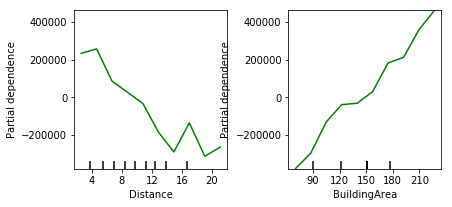

In [3]:
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence

# get_some_data is defined in hidden cell above.
X, y = get_some_data()
# scikit-learn originally implemented partial dependence plots only for Gradient Boosting models
# this was due to an implementation detail, and a future release will support all model types.
my_model = GradientBoostingRegressor()
# fit the model as usual
my_model.fit(X, y)
# Here we make the plot
my_plots = plot_partial_dependence(my_model,       
                                   features=[0, 2], # column numbers of plots we want to show
                                   X=X,            # raw predictors data.
                                   feature_names=['Distance', 'Landsize', 'BuildingArea'], # labels on graphs
                                   grid_resolution=10) # number of values to plot on x axis

Some tips related to plot_partial_dependence:
* The features are the column numbers from the X array or dataframe that you wish to have plotted.  This starts to look bad beyond 2 or 3 variables.  You could make repeated calls to plot 2 or 3 at a time.
* There are options to establish what points on the horizontal axis are plotted.  The simplest is *grid_resolution* which we use to determine how many different points are plotted.  These plots tend to look jagged as that value increases, because you will pick up lots of randomness or noise in your model.  It's best not to take the small or jagged fluctuations too literally.  Smaller values of grid_resolution smooth this out.  It's also much less of an issue for datasets with many rows.
* There is a function called *partial_dependence* to get the raw data making up this plot, rather than making the visual plot itself. This is useful if you want to control how it is visualized using a plotting package like Seaborn.  With moderate effort, you could make much nicer looking plots.

## Another Example

Here are partial plots from a very simple model on the Titanic data.

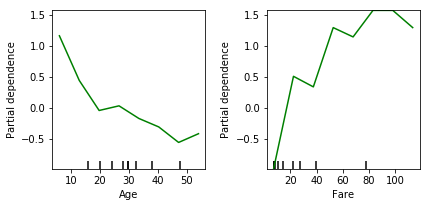

In [4]:
titanic_data = pd.read_csv('./data/titanic/train.csv')

titanic_y = titanic_data.Survived
titanic_X_colns = ['PassengerId','Age', 'Fare',]
titanic_X = titanic_data[titanic_X_colns]

my_imputer = Imputer()
imputed_titanic_X = my_imputer.fit_transform(titanic_X)

clf = GradientBoostingClassifier()
clf.fit(imputed_titanic_X, titanic_y)

titanic_plots = plot_partial_dependence(clf, features=[1,2], X=imputed_titanic_X, 
                                        feature_names=titanic_X_colns, grid_resolution=8)

These might seem surprising at first glance.  But they show some interesting insights:
* Being young increased your odds of survival. This is consistent with historical recountings that they got women and children off the Titanic first.
* People who paid more had better odds of survival.  It turns out that higher fares got you a cabin that was closer to the top of the boat, and may have given you better odds of getting a life-boat.

# Conclusion
Partial dependence plots are a great way (though not the only way) to extract insights from complex models.  These can be incredibly powerful for communicating those insights to colleagues or non-technical users. 

There are a variety of opinions on how to interpret these plots when they come from non-experimental data.  Some claim you can conclude nothing about cause-and-effect relationships from data unless it comes from experiments. Others are more positive about what can be learned from non-experimental data (also called observational data). It's a divisive topic in the data science world, beyond the scope of this tutorial.

However most agree that these are useful to understand your model.  Also, given the messiness of most real-world data sources, it's also a good sanity check that your model is capturing realistic patterns.

The *partial_dependence_plot* function is an easy way to get these plots, though the results aren't visually beautiful.  The *partial_dependence* function gives you the raw data, in case you want to make presentation-quality graphs.

# Your Turn
Pick three predictors in your project.  Formulate an hypothesis about what the partial dependence plot will look like.  Create the plots, and check the results against your hypothesis.

Once you've done that, **[click here](https://www.kaggle.com/dansbecker/learn-machine-learning)** to return to Learning Machine Learning, where you will keep improving your results.

In [5]:
import pandas as pd
from sklearn.preprocessing import Imputer

data = pd.read_csv('./data/house-prices-advanced-regression-techniques/train.csv')
data.dropna(axis=0, subset=['SalePrice'], inplace=True)

y = data['SalePrice']
X = data.drop(['SalePrice'], axis=1).select_dtypes(exclude=['object'])

cols_to_use = ['YearBuilt', 'LotArea', 'OverallQual', 'OverallCond']

X = X[cols_to_use]

my_imputer = Imputer()
X_imputed = my_imputer.fit_transform(X)

In [6]:
reg = GradientBoostingRegressor()
reg.fit(X_imputed, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

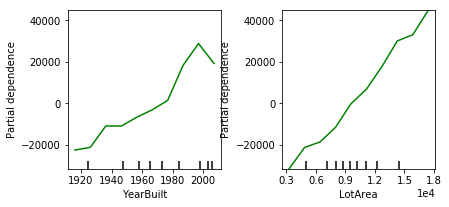

In [7]:
plot = plot_partial_dependence(reg,
                       features=[0, 1],
                       X=X_imputed,
                       feature_names=cols_to_use,
                       grid_resolution=10)

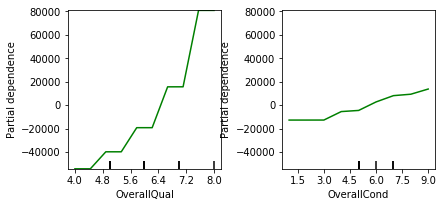

In [8]:
plot = plot_partial_dependence(reg,
                       features=[2, 3],
                       X=X_imputed,
                       feature_names=cols_to_use,
                       grid_resolution=10)